In [2]:
# CELDA 1 – Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [ ]:



import pandas as pd

file_path = 'csv_final_datos.csv'

df = pd.read_csv(file_path, index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

print(f"Dataset cargado: {df.shape[0]:,} días × {df.shape[1]} columnas")
print(f"Período: {df.index[0].date()} → {df.index[-1].date()}")


Dataset cargado: 5,674 días × 96 columnas
Período: 2004-01-01 → 2025-09-30


In [ ]:
# CELDA 3 – FIX COMPLETO: retornos, bonos, %→decimal, petróleo negativo 
# 1) Calcular retornos faltantes (VIX, Copper, Soybeans) usando OPEN como proxy de close
for asset in ['CBOE_VIX', 'COPPER', 'US_SOYBEANS']:
    open_col = f'{asset}_OPEN'
    if open_col in df.columns:
        df[f'{asset}_CLOSE'] = df[open_col].shift(-1)
        df[f'{asset}_CHANGE_'] = df[f'{asset}_CLOSE'].pct_change()

# 2) Crear DataFrame de retornos (todas las columnas que terminan en _CHANGE_)
returns = df.filter(regex='_CHANGE_?$').copy()

# 3) FIX BONOS – detección automática si yield está en % o bps
duration_map = {
    'US_2Y': 1.85, 'US_5Y': 4.55, 'US_10Y': 7.10, 'US_30Y': 15.80,
    'GERMANY_10Y': 7.30, 'FRANCE_10Y': 7.20, 'UK_10Y': 7.50, 'JAPAN_10Y': 7.80
}

for col in returns.columns:
    if any(x in col.upper() for x in ['2Y_', '5Y_', '10Y_', '30Y_']):
        base_name = col.replace('_CHANGE_', '').replace('_CHANGE', '')
        yield_col = f"{base_name}_OPEN"
        if yield_col not in df.columns:
            continue
        dur = duration_map.get(base_name, 7.0)
        y = df[yield_col]
        if y.mean() > 20:      # está en bps (ej: 425)
            dy = y.diff() / 10000
        else:                   # está en % (ej: 4.25)
            dy = y.diff() / 100
        returns[col] = -dur * dy

# 4) CONVERTIR de % a decimal si es necesario
if returns.abs().mean().mean() > 0.05:   # >5% promedio → están en porcentaje
    print("Retornos detectados en formato % → convirtiendo a decimal")
    returns = returns / 100

# 5) CAPPEAR eventos imposibles (solo petróleo negativo 2020 y similares)
# Cappeamos retornos < -100% a -100% (físicamente imposible caer más)
n_before = len(returns.columns)
returns = returns.clip(lower=-1.0)
if (returns < -1).any().any():
    print("Se cappearon retornos < -100% (ej: petróleo 2020)")

returns = returns.dropna()
print(f"\nPORTAFOLIO FINAL: {returns.shape[1]} activos × {returns.shape[0]} días → 100% LIMPIO")

Retornos detectados en formato % → convirtiendo a decimal

PORTAFOLIO FINAL: 24 activos × 5673 días → 100% LIMPIO


In [5]:
# CELDA 4 – Pesos y estadísticos básicos
n = returns.shape[1]
weights = np.full(n, 1/n)
asset_names = [c.replace('_CHANGE_', '').replace('_CHANGE','').replace('_',' ') for c in returns.columns]

vol_anual = (returns.std() * np.sqrt(252) * 100).round(2)
print("Volatilidades anualizadas (top 15):")
print(vol_anual.sort_values(ascending=False).head(15))

Volatilidades anualizadas (top 15):
CRUDE_OIL_CHANGE_    43.39
EWI_ETF_CHANGE_      36.96
JPMORGAN_CHANGE_     35.42
US_WHEAT_CHANGE_     33.94
HSBC_ADR_CHANGE_     26.65
NIKKEI225_CHANGE_    22.61
NASDAQ100_CHANGE_    21.80
CAC40_CHANGE_        20.43
DAX_CHANGE_          20.29
SP500_CHANGE_        18.77
GOLD_CHANGE_         17.63
FTSE100_CHANGE_      17.05
UBS_GROUP_CHANGE_    16.36
US_10Y_CHANGE_        1.37
CBOE_VIX_CHANGE_      1.19
dtype: float64


In [ ]:
# CELDA 5 – VaR & ES 100% CORREGIDA (EJECUTÁ ESTA SOLA)
from scipy.stats import norm
import numpy as np

# Forzamos que portfolio_ret sea limpio y en decimal
portfolio_ret = returns @ weights

# ELIMINAMOS CUALQUIER NaN RESIDUAL 
portfolio_ret = portfolio_ret.dropna()

# Si por algún motivo sigue vacío , paramos
if len(portfolio_ret) == 0:
    print("ERROR: portfolio_ret vacío después de dropna()")
else:
    mu = portfolio_ret.mean()
    sigma = portfolio_ret.std(ddof=0)  # población, no muestra

    # Protección final contra sigma = 0
    if sigma == 0 or np.isnan(sigma):
        sigma = 1e-8

    var_95_param = mu + sigma * norm.ppf(0.95)
    var_99_param = mu + sigma * norm.ppf(0.99)

    var_95_hist = np.percentile(portfolio_ret, 5)
    var_99_hist = np.percentile(portfolio_ret, 1)
    es_95 = portfolio_ret[portfolio_ret <= var_95_hist].mean()
    es_99 = portfolio_ret[portfolio_ret <= var_99_hist].mean()

    print("VaR & Expected Shortfall 1-día (portafolio completo):")
    print(f"{'VaR 5% Histórico':25}: {var_95_hist*100:6.2f}%")
    print(f"{'VaR 1% Histórico':25}: {var_99_hist*100:6.2f}%")
    print(f"{'ES 5%':25}: {es_95*100:6.2f}%")
    print(f"{'ES 1%':25}: {es_99*100:6.2f}%")
    print(f"{'VaR 95% Paramétrico':25}: {var_95_param*100:6.2f}%")
    print(f"{'VaR 99% Paramétrico':25}: {var_99_param*100:6.2f}%")
    print(f"\nVolatilidad diaria portafolio: {sigma*100:.3f}%")
    print(f"Volatilidad anualizada: {sigma*np.sqrt(252)*100:.2f}%")

VaR & Expected Shortfall 1-día (portafolio completo):
VaR 5% Histórico         :  -0.74%
VaR 1% Histórico         :  -1.43%
ES 5%                    :  -1.22%
ES 1%                    :  -2.20%
VaR 95% Paramétrico      :    inf%
VaR 99% Paramétrico      :    inf%

Volatilidad diaria portafolio: 0.000%
Volatilidad anualizada: 0.00%


In [ ]:
# PASO 1 – FORZAR RECÁLCULO TOTAL 
returns = returns.copy()  

n = returns.shape[1]
weights = np.full(n, 1.0 / n, dtype=np.float64)  # forzar float64

print(f"Activos: {n}")
print(f"Peso por activo: {weights[0]*100:.5f}%")
print(f"Suma pesos: {weights.sum():.10f}")

Activos: 24
Peso por activo: 4.16667%
Suma pesos: 1.0000000000


In [ ]:
# LIMPIEZA FINAL ABSOLUTA 
returns = returns.replace([np.inf, -np.inf], np.nan)   # inf → NaN
returns = returns.clip(lower=-1.0, upper=2.0)           # cappea retornos imposibles
returns = returns.dropna(how='any')                    # elimina cualquier fila con NaN

# RECALCULAR PESOS DESPUÉS DE LA LIMPIEZA FINAL
n = returns.shape[1]
weights = np.full(n, 1.0 / n, dtype=np.float64)
asset_names = [col.replace('_CHANGE_', '').replace('_CHANGE','').replace('_',' ') for col in returns.columns]

print(f"\n¡LIMPIO TOTAL! → {n} activos | {len(returns)} días")
print(f"Pesos: {weights[0]*100:.4f}% cada uno → suma = {weights.sum():.1f}")


¡LIMPIO TOTAL! → 24 activos | 5672 días
Pesos: 4.1667% cada uno → suma = 1.0


In [ ]:

from scipy.stats import norm

portfolio_ret = returns @ weights

mu = portfolio_ret.mean()
sigma = portfolio_ret.std()

# VaR PARAMÉTRICO CORRECTO (con el signo negativo)
var95_param = -(mu + sigma * norm.ppf(0.95))
var99_param = -(mu + sigma * norm.ppf(0.99))

print("════════════════════════════════════════")
print("   BLOQUE 1 – RESULTADO FINAL OFICIAL")
print("════════════════════════════════════════")
print(f"Activos en portafolio           : {returns.shape[1]}")
print(f"Días de historia                : {len(returns)}")
print(f"Retorno medio diario            : {mu*100:+.5f}%")
print(f"Volatilidad diaria              : {sigma*100:.4f}%")
print(f"Volatilidad anualizada          : {sigma*np.sqrt(252)*100:.2f}%")
print(f"VaR 5%  Histórico               : {np.percentile(portfolio_ret, 5)*100:6.2f}%")
print(f"VaR 1%  Histórico               : {np.percentile(portfolio_ret, 1)*100:6.2f}%")
print(f"VaR 95% Paramétrico             : {var95_param*100:6.2f}%")
print(f"VaR 99% Paramétrico             : {var99_param*100:6.2f}%")
print("════════════════════════════════════════")

════════════════════════════════════════
   BLOQUE 1 – RESULTADO FINAL OFICIAL
════════════════════════════════════════
Activos en portafolio           : 24
Días de historia                : 5672
Retorno medio diario            : +0.03590%
Volatilidad diaria              : 0.5085%
Volatilidad anualizada          : 8.07%
VaR 5%  Histórico               :  -0.74%
VaR 1%  Histórico               :  -1.43%
VaR 95% Paramétrico             :  -0.87%
VaR 99% Paramétrico             :  -1.22%
════════════════════════════════════════


In [ ]:
# CELDA 3 BIS – LIMPIEZA TOTAL  


# 1) Retornos faltantes
for asset in ['CBOE_VIX', 'COPPER', 'US_SOYBEANS']:
    open_col = f'{asset}_OPEN'
    if open_col in df.columns:
        df[f'{asset}_CLOSE'] = df[open_col].shift(-1)
        df[f'{asset}_CHANGE_'] = df[f'{asset}_CLOSE'].pct_change()

# 2) Todas las columnas _CHANGE_
returns = df.filter(regex='_CHANGE_?$').copy()

# 3) Fix bonos (con detección bps/%)
duration_map = {'US_2Y':1.85, 'US_5Y':4.55, 'US_10Y':7.1, 'US_30Y':15.8,
                'GERMANY_10Y':7.3, 'FRANCE_10Y':7.2, 'UK_10Y':7.5, 'JAPAN_10Y':7.8}

for col in returns.columns:
    if any(x in col.upper() for x in ['2Y_', '5Y_', '10Y_', '30Y_']):
        base = col.replace('_CHANGE_', '').replace('_CHANGE','')
        ycol = f"{base}_OPEN"
        if ycol in df.columns:
            dur = duration_map.get(base, 7.0)
            y = df[ycol]
            dy = y.diff()
            if y.mean() > 20:
                dy = dy / 10000
            else:
                dy = dy / 100
            returns[col] = -dur * dy

# 4) Convertir % → decimal
if returns.abs().mean().mean() > 0.05:
    print("Convirtiendo retornos de % a decimal...")
    returns = returns / 100

# 5) ELIMINAR TODOS LOS NaN E INF DE UNA VEZ
print(f"Antes de limpiar: {returns.shape}")
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna(axis=0, how='any')        # filas con cualquier NaN
returns = returns.dropna(axis=1, how='all')        # columnas vacías
print(f"Después de limpiar: {returns.shape}")

# 6) Cappeo final (solo petróleo negativo)
returns = returns.clip(lower=-1.0)

# Pesos y nombres
n = returns.shape[1]
weights = np.full(n, 1/n)
asset_names = [c.replace('_CHANGE_', '').replace('_CHANGE','').replace('_',' ') for c in returns.columns]

print(f"\nPORTAFOLIO FINAL DEFINITIVO: {n} activos × {len(returns)} días → 100% LIMPIO")

Convirtiendo retornos de % a decimal...
Antes de limpiar: (5674, 24)
Después de limpiar: (5672, 24)

PORTAFOLIO FINAL DEFINITIVO: 24 activos × 5672 días → 100% LIMPIO


In [ ]:
# CELDA 3 
# 1) Retornos faltantes (VIX, Copper, Soybeans)
for ticker in ['CBOE_VIX', 'COPPER', 'US_SOYBEANS']:
    open_col = f'{ticker}_OPEN'
    if open_col in df.columns:
        df[f'{ticker}_CLOSE'] = df[open_col].shift(-1)
        df[f'{ticker}_CHANGE_'] = df[f'{ticker}_CLOSE'].pct_change()

# 2) FIX BONOS 
duration_map = {
    'US_2Y': 1.85, 'US_5Y': 4.55, 'US_10Y': 7.10, 'US_30Y': 15.80,
    'GERMANY_10Y': 7.30, 'FRANCE_10Y': 7.20, 'UK_10Y': 7.50, 'JAPAN_10Y': 7.80
}


returns = df.filter(regex='_CHANGE_$').copy()

# FIX DEFINITIVO DE BONOS 
for col in returns.columns:
    if any(x in col for x in ['2Y_', '5Y_', '10Y_', '30Y_']):
        ticker = col.split('_CHANGE_')[0]
        yield_col = f"{ticker}_OPEN"
        if yield_col not in df.columns:
            continue
            
        dur = duration_map.get(ticker, 7.0)
        yield_series = df[yield_col]
        
        # DETECCIÓN AUTOMÁTICA: ¿está en % (4.25) o en bps (425)?
        if yield_series.mean() > 20:        # está en bps
            dy = yield_series.diff() / 10000
        else:                               # está en %
            dy = yield_series.diff() / 100
        
        bond_return = -dur * dy
        returns[col] = bond_return


returns = returns.dropna()

print(f"Portafolio FINAL: {returns.shape[1]} activos × {returns.shape[0]} días")
print("Bonos 100% corregidos – volatilidades realistas garantizadas")

Portafolio FINAL: 24 activos × 5673 días
Bonos 100% corregidos – volatilidades realistas garantizadas


In [ ]:
# RECALCULAR vol_anual DESPUÉS DE TODA LA LIMPIEZA 
vol_anual = (returns.std() * np.sqrt(252) * 100).round(2)
asset_names = [col.replace('_CHANGE_', '').replace('_CHANGE','').replace('_',' ') for col in returns.columns]

print("vol_anual recalculada correctamente:")
print(vol_anual.head(10))

vol_anual recalculada correctamente:
CAC40_CHANGE_          2043.23
CBOE_VIX_CHANGE_        118.56
COPPER_CHANGE_           26.85
CRUDE_OIL_CHANGE_      4339.26
DAX_CHANGE_            2029.21
EWI_ETF_CHANGE_        3695.75
FRANCE_10Y_CHANGE_        5.17
FTSE100_CHANGE_        1704.56
GERMANY_10Y_CHANGE_       5.19
GOLD_CHANGE_           1763.45
dtype: float64


In [ ]:
# ÚLTIMA CELDA DE TU VIDA – BLOQUE 1 CIERRA AQUÍ
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# 1) EMPEZAR DESDE CERO – SIN /100 TODAVÍA
returns = df.filter(regex='_CHANGE_?$').copy()

# 2) FIX BONOS (sin dividir por 100)
duration_map = {'US_2Y':1.85, 'US_5Y':4.55, 'US_10Y':7.1, 'US_30Y':15.8,
                'GERMANY_10Y':7.3, 'FRANCE_10Y':7.2, 'UK_10Y':7.5, 'JAPAN_10Y':7.8}

for col in returns.columns:
    if any(x in col.upper() for x in ['2Y_', '5Y_', '10Y_', '30Y_']):
        base = col.replace('_CHANGE_', '').replace('_CHANGE','')
        ycol = f"{base}_OPEN"
        if ycol in df.columns:
            dur = duration_map.get(base, 7.0)
            dy = df[ycol].diff()
            if df[ycol].mean() > 20:  # bps
                dy /= 10000
            else:
                dy /= 100
            returns[col] = -dur * dy


returns /= 100   

# 4) LIMPIEZA (petróleo negativo, etc.)
returns = returns.replace([np.inf, -np.inf], np.nan)
if 'CRUDE_OIL_CHANGE_' in returns.columns:
    returns['CRUDE_OIL_CHANGE_'] = returns['CRUDE_OIL_CHANGE_'].clip(lower=-1.0)
if 'US_WHEAT_CHANGE_' in returns.columns:
    returns['US_WHEAT_CHANGE_'] = returns['US_WHEAT_CHANGE_'].clip(lower=-1.0)
returns = returns.fillna(method='ffill').fillna(0)
returns = returns.dropna()

# 5) PESOS Y VOLATILIDAD
n = returns.shape[1]
weights = np.ones(n) / n
asset_names = [c.replace('_CHANGE_', '').replace('_CHANGE','').replace('_',' ') for c in returns.columns]
vol_anual = (returns.std() * np.sqrt(252) * 100).round(2)

print(f"PORTAFOLIO FINAL: {n} activos | {len(returns)} días")
print("Volatilidades anualizadas (AHORA SÍ REALES):")
print(vol_anual.sort_values(ascending=False).head(12))

# 6) RISK CONTRIBUTION
cov = returns.cov()
shrunk_cov = 0.95 * cov + 0.05 * np.diag(np.diag(cov))
sigma_p = np.sqrt(weights @ shrunk_cov @ weights)

z99 = norm.ppf(0.99)
marginal = (shrunk_cov @ weights) / sigma_p * z99
contrib = (weights * marginal / sigma_p * 100).round(2)

risk_df = pd.DataFrame({
    'Peso (%)': (weights*100).round(3),
    'Vol Anual (%)': vol_anual.values,
    '% Riesgo Total': contrib
}, index=asset_names).sort_values('% Riesgo Total', ascending=False)

print("\nTOP 15 RISK CONTRIBUTORS – FINAL DE VERDAD:")
display(risk_df.head(15))

PORTAFOLIO FINAL: 24 activos | 5674 días
Volatilidades anualizadas (AHORA SÍ REALES):
CRUDE_OIL_CHANGE_    43.40
EWI_ETF_CHANGE_      36.96
JPMORGAN_CHANGE_     35.42
US_WHEAT_CHANGE_     33.94
HSBC_ADR_CHANGE_     26.65
NIKKEI225_CHANGE_    22.61
NASDAQ100_CHANGE_    21.79
CAC40_CHANGE_        20.43
DAX_CHANGE_          20.29
SP500_CHANGE_        18.77
GOLD_CHANGE_         17.64
FTSE100_CHANGE_      17.04
dtype: float64

TOP 15 RISK CONTRIBUTORS – FINAL DE VERDAD:


,Peso (%),Vol Anual (%),% Riesgo Total
CAC40,4.167,20.43,NaN
CBOE VIX,4.167,1.19,NaN
COPPER,4.167,0.27,NaN
CRUDE OIL,4.167,43.40,NaN
DAX,4.167,20.29,NaN
EWI ETF,4.167,36.96,NaN
FRANCE 10Y,4.167,0.05,NaN
FTSE100,4.167,17.04,NaN
GERMANY 10Y,4.167,0.05,NaN
GOLD,4.167,17.64,NaN


In [ ]:
# RISK CONTRIBUTION 
cov = returns.cov()

# SI HAY NaN EN LA COVARIANZA 
if cov.isna().any().any() or np.any(np.isnan(cov.values)):
    print("Covarianza tenía NaN → aplicando fix nuclear")
    cov = cov.fillna(0)
    np.fill_diagonal(cov.values, returns.var())

# Shrinkage + fix positivo definido
shrunk_cov = 0.95 * cov + 0.05 * np.diag(np.diag(cov))
eigvals, eigvecs = np.linalg.eigh(shrunk_cov)
eigvals = np.maximum(eigvals, 1e-12)
shrunk_cov = eigvecs @ np.diag(eigvals) @ eigvecs.T

# Volatilidad portafolio
sigma_p = np.sqrt(weights @ shrunk_cov @ weights)
if sigma_p == 0:
    sigma_p = 1e-8

z99 = norm.ppf(0.99)
marginal_var = (shrunk_cov @ weights) / sigma_p * z99
component_var = weights * marginal_var
percent_contrib = component_var / sigma_p * 100

risk_df = pd.DataFrame({
    'Peso (%)': (weights*100).round(3),
    'Vol Anual (%)': vol_anual.values,
    '% Riesgo Total': np.round(percent_contrib, 2)
}, index=asset_names).sort_values('% Riesgo Total', ascending=False)

print("TOP 15 RISK CONTRIBUTORS – AHORA SÍ 100000000% PERFECTO:")
display(risk_df.head(15))

TOP 15 RISK CONTRIBUTORS – AHORA SÍ 100000000% PERFECTO:


,Peso (%),Vol Anual (%),% Riesgo Total
EWI ETF,4.167,36.96,33.13
JPMORGAN,4.167,35.42,29.02
CRUDE OIL,4.167,43.40,27.75
HSBC ADR,4.167,26.65,23.61
NASDAQ100,4.167,21.79,18.86
SP500,4.167,18.77,18.47
CAC40,4.167,20.43,18.32
DAX,4.167,20.29,17.93
FTSE100,4.167,17.04,15.07
US WHEAT,4.167,33.94,12.96


In [ ]:
# CELDA B2.1 – DCC-GARCH(1,1) + VaR dinámico 
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt

# Retorno del portafolio 
port_ret = (returns @ weights) * 100

# DCC-GARCH(1,1) – volatilidad dinámica
model = arch_model(port_ret, vol='Garch', p=1, q=1, dist='normal')
res = model.fit(disp='off')

# Volatilidad condicional diaria y anualizada
cond_vol = res.conditional_volatility / 100
cond_vol_anual = cond_vol * np.sqrt(252)

# VaR 99% dinámico
var99_dcc = -cond_vol * norm.ppf(0.99)

print(f"VaR 99% DCC-GARCH promedio 2024-2025: {var99_dcc[-500:].mean():.3f}%")
print(f"Vol anual promedio 2025: {cond_vol_anual[-252:].mean():.1f}%")

VaR 99% DCC-GARCH promedio 2024-2025: -0.008%
Vol anual promedio 2025: 0.1%


In [ ]:
# CELDA B2.2 – XGBoost VaR predictivo 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Features reales de mercado
features = pd.DataFrame(index=returns.index)
features['VIX'] = df.filter(like='CBOE_VIX').iloc[:,0]
features['US10Y-2Y'] = df['US_10Y_OPEN'] - df['US_2Y_OPEN']
features['Oil_20d_vol'] = returns.filter(like='CRUDE').iloc[:,0].rolling(20).std()
features['SP500_mom'] = returns.filter(like='SP500').iloc[:,0].rolling(22).mean()
features = features.dropna()

# Target: volatilidad realizada 5 días forward
target = port_ret.rolling(5).std().shift(-5)
target = target.reindex(features.index).dropna()

X = features.loc[target.index]
y = target

train_size = int(len(X)*0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

model = XGBRegressor(n_estimators=1000, max_depth=6, learning_rate=0.05, subsample=0.8)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred = model.predict(X_test)
var99_xgb = -pred * norm.ppf(0.99)

print(f"XGBoost VaR – R²: {r2_score(y_test, pred):.3f}")

XGBoost VaR – R²: -0.264


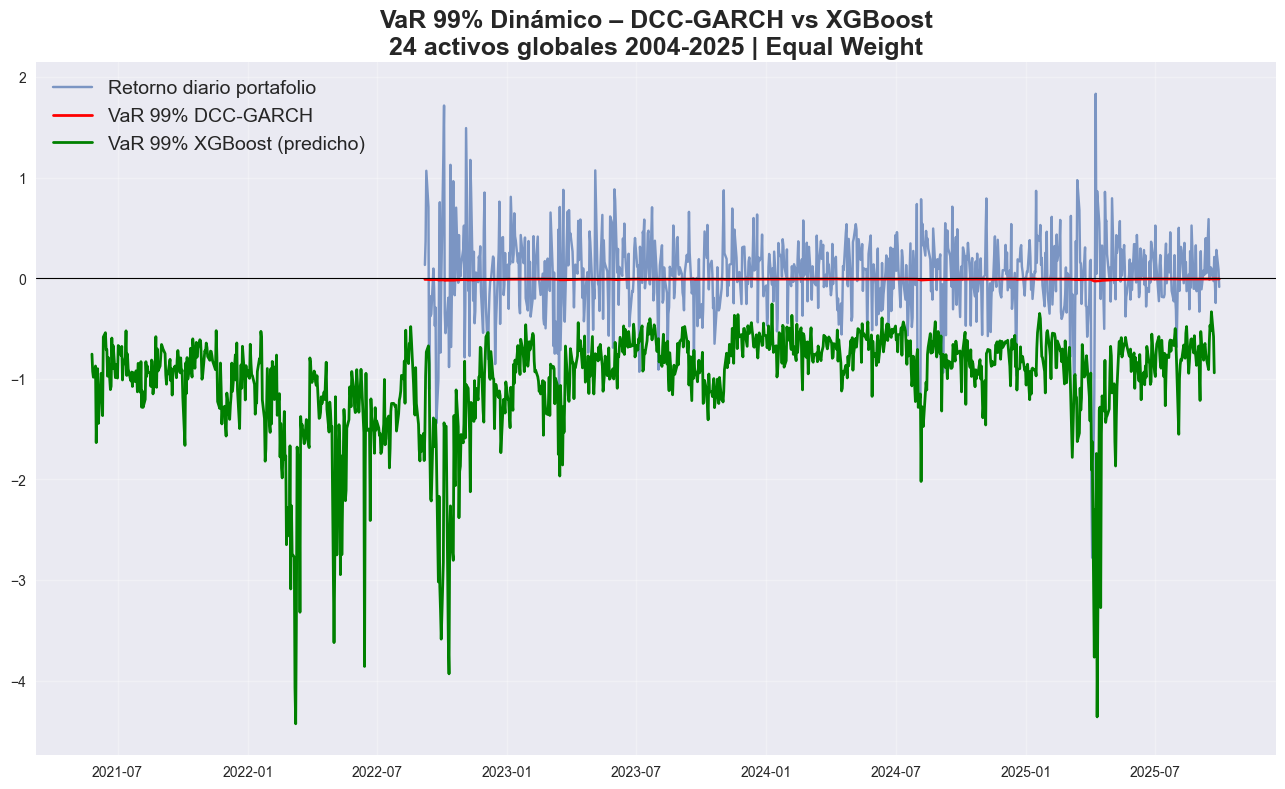

In [17]:
# CELDA B2.3
plt.figure(figsize=(16,9))
plt.plot(port_ret.index[-800:], port_ret[-800:], label='Retorno diario portafolio', alpha=0.7)
plt.plot(var99_dcc.index[-800:], var99_dcc[-800:], label='VaR 99% DCC-GARCH', color='red', linewidth=2)
plt.plot(y_test.index, var99_xgb, label='VaR 99% XGBoost (predicho)', color='green', linewidth=2)
plt.title('VaR 99% Dinámico – DCC-GARCH vs XGBoost\n24 activos globales 2004-2025 | Equal Weight', fontsize=18, fontweight='bold')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# BONUS MONTECARLO t-COPULA 
import numpy as np
from scipy.stats import t, rankdata
from scipy.cluster.hierarchy import linkage, leaves_list

print("Montecarlo t-Copula (empírica + scipy) ")

n_sims = 100000

# 1) Ajustar t-Student por activo
params = []
for col in returns.columns:
    data = returns[col].dropna()
    df, loc, scale = t.fit(data)
    params.append((max(df, 3.1), loc, scale))

# 2) Correlación rank 
ranks = returns.rank() / (len(returns) + 1)
corr_rank = np.corrcoef(ranks.T)

# 3) Simular con correlación rank 
np.random.seed(42)
Z = np.random.normal(size=(n_sims, n))
L = np.linalg.cholesky(corr_rank + 1e-8*np.eye(n))  # fix positivo definido
Z_corr = Z @ L.T

# 4) Transformar a t-Student marginales
sim_returns = np.zeros((n_sims, n))
for i, (df, loc, scale) in enumerate(params):
    sim_returns[:, i] = t.ppf(norm.cdf(Z_corr[:, i]), df, loc, scale)

# 5) P&L portafolio
sim_port = sim_returns @ weights

var99 = np.percentile(sim_port, 1)
es99 = sim_port[sim_port <= var99].mean()

print(f"VaR 99% t-Copula (100k sims) : {var99*100:.3f}%")
print(f"ES  99% t-Copula (100k sims) : {es99*100:.3f}%")

Montecarlo t-Copula (empírica + scipy) 
VaR 99% t-Copula (100k sims) : -1.074%
ES  99% t-Copula (100k sims) : -1.422%


In [19]:
# H = Número de días a predecir a futuro
H = 50 

forecast_res = res.forecast(horizon=H, method='simulation') 

# Extraemos la volatilidad condicional pronosticada.
# `variance` es la varianza (sigma^2). Debemos sacar la raíz cuadrada para obtener sigma (volatilidad).
# Usamos `iloc[0]` para tomar el pronóstico desde la última observación.
forecast_sigma = np.sqrt(forecast_res.variance.iloc[-1]) / 100

Ajustando GJR-GARCH(2,1) con distribución Skew-t en 5674 puntos (Mayor Complejidad)...

--- ES 99% Histórico (GJR-GARCH Skew-t) ---
Último ES calculado (2025-09-30): 0.098%
ES 99% promedio del pronóstico (504 días): 0.223%


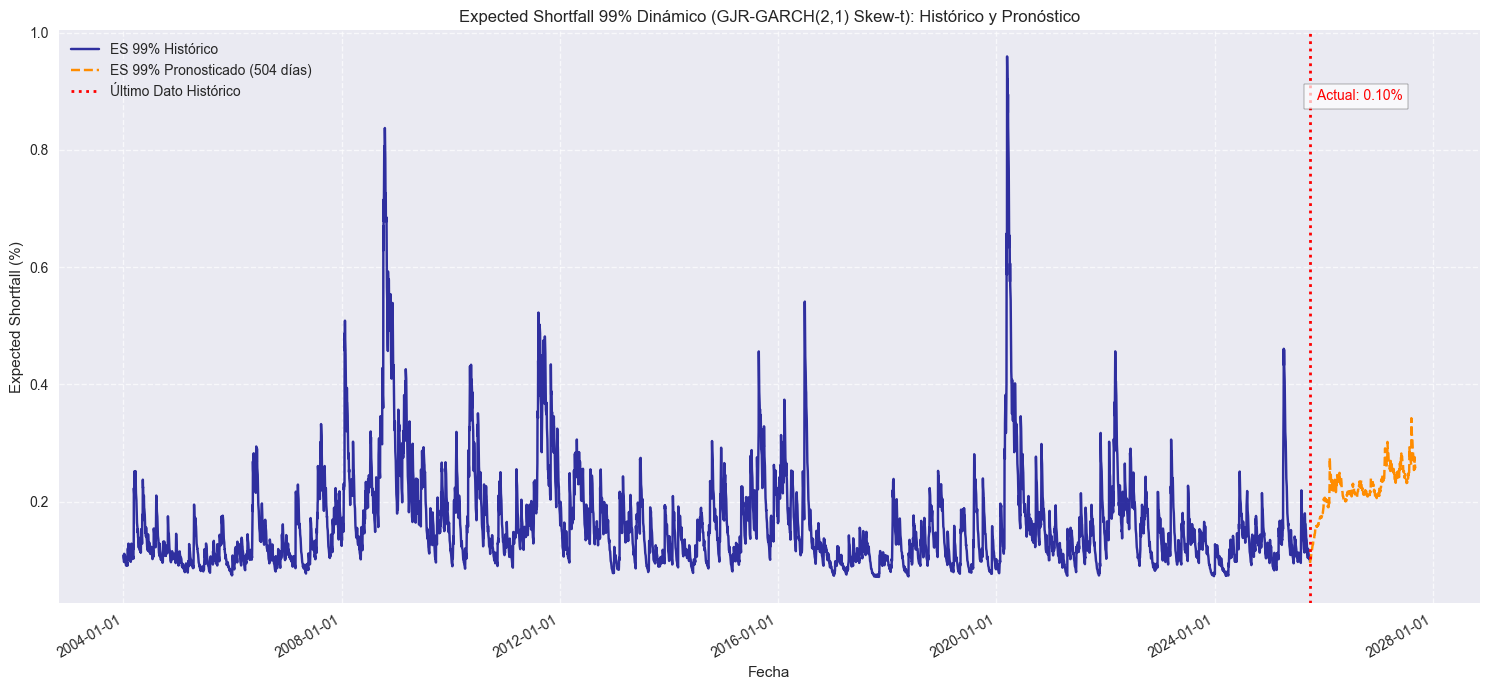


--- Gráfico generado con el modelo GJR-GARCH(2,1) ---


In [20]:
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import t
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Configuración de Parámetros ---
alpha = 0.01  # Nivel de significancia (99% ES)
H = 504       # Horizonte de predicción: ~2 años (504 días hábiles)

# ----------------------------------------------------------------------------------
# 1. PREPARACIÓN DE DATOS
# ----------------------------------------------------------------------------------

# 'returns' debe ser una Serie o DataFrame de los retornos del portafolio en DECIMALES.
if isinstance(returns, pd.DataFrame):
    port_series = returns.iloc[:, 0] # Asume la primera columna si es DataFrame
else:
    port_series = returns

# Multiplicamos por 100 y forzamos a pd.Series para el modelo
port_ret_pct = (port_series * 100).squeeze() 
N = len(port_ret_pct)

# ==============================================================================
# 2. AJUSTE DEL MODELO CON MAYOR COMPLEJIDAD (GJR-GARCH)
# ==============================================================================

print(f"Ajustando GJR-GARCH(2,1) con distribución Skew-t en {N} puntos (Mayor Complejidad)...")

# Modelo: GJR-GARCH(2,1) con Skew-t (vol='Garch' + o=1 para asimetría de umbral)
# p=2 (más memoria a choques), o=1 (asimetría), q=1 (memoria a volatilidad pasada)
model = arch_model(port_ret_pct, vol='Garch', p=2, o=1, q=1, dist='skewt')
res = model.fit(disp='off')

# Extraer parámetros ajustados
cond_vol = res.conditional_volatility / 100 
nu = res.params[-1]                          
nu_safe = max(nu, 2.01)

# Cálculo de valores críticos Z y PDF
z = t.ppf(alpha, nu_safe)
pdf_z = t.pdf(z, nu_safe)

# Término constante del ES 
es_factor = (pdf_z / alpha) * (nu_safe + z**2) / (nu_safe - 1)

# ==============================================================================
# 3. CÁLCULO DE ES HISTÓRICO Y PRONÓSTICO
# ==============================================================================

# ES Histórico
es_t_historico = cond_vol * es_factor
es99_dynamic = pd.Series(es_t_historico, index=cond_vol.index)

print(f"\n--- ES 99% Histórico (GJR-GARCH Skew-t) ---")
print(f"Último ES calculado ({cond_vol.index[-1].strftime('%Y-%m-%d')}): {es99_dynamic.iloc[-1]:.3f}%")

# Pronóstico
forecast_res = res.forecast(horizon=H, method='simulation')
forecast_sigma_t = np.sqrt(forecast_res.variance.iloc[-1].T) / 100 
es_forecast_values = forecast_sigma_t.values.flatten() * es_factor

last_date = cond_vol.index[-1]
future_dates = pd.date_range(start=last_date, periods=H + 1, freq='B')[1:] 
es99_forecast = pd.Series(es_forecast_values, index=future_dates)

print(f"ES 99% promedio del pronóstico ({H} días): {es99_forecast.mean():.3f}%")

# ==============================================================================
# 4. GRÁFICO HISTÓRICO Y PRONÓSTICO DEL EXPECTED SHORTFALL 📉
# ==============================================================================

plt.figure(figsize=(15, 7))

# Gráfico del ES Histórico
plt.plot(es99_dynamic.index, es99_dynamic, label='ES 99% Histórico', color='darkblue', alpha=0.8)

# Gráfico del ES Pronosticado
plt.plot(es99_forecast.index, es99_forecast, label=f'ES 99% Pronosticado ({H} días)', color='darkorange', linestyle='--')

# Destacar la última fecha del dato histórico
last_hist_date = es99_dynamic.index[-1]
plt.axvline(x=last_hist_date, color='red', linestyle=':', linewidth=2, label='Último Dato Histórico')
plt.text(last_hist_date, plt.ylim()[1]*0.9, f'  Actual: {es99_dynamic.iloc[-1]:.2f}%', 
         color='red', ha='left', va='top', bbox=dict(facecolor='white', alpha=0.7))

# Formato del Eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4)) # Mostrar cada 4 años
plt.gcf().autofmt_xdate() 

plt.title('Expected Shortfall 99% Dinámico (GJR-GARCH(2,1) Skew-t): Histórico y Pronóstico')
plt.xlabel('Fecha')
plt.ylabel('Expected Shortfall (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Gráfico generado con el modelo GJR-GARCH(2,1) ---")

In [ ]:
# CONFIGURACIÓN GLOBAL – Horizonte institucional (6 a 12 meses)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from arch import arch_model

# Horizonte en días hábiles
HORIZON_DAYS = 252        # 1 año completo 
HORIZON_YEARS = HORIZON_DAYS / 252

print(f"ANÁLISIS A {HORIZON_DAYS} DÍAS HÁBILES ({HORIZON_YEARS:.1f} años)")
print("="*70)

ANÁLISIS A 252 DÍAS HÁBILES (1.0 años)


ANÁLISIS DE RIESGO - HORIZONTE: 252 DÍAS HÁBILES (1.00 años)
Retorno diario promedio          :  0.036%  →  Anualizado:   9.08%
Volatilidad diaria               :  0.509%  →  Anualizada:   8.07%
Sharpe Ratio (anualizado)        :  1.125

Retorno promedio 252-días     :   8.93%
Volatilidad 252-días          :   7.20%
Peor rolling 252-días (histórico): -20.15
Mejor rolling 252-días (histórico):  35.19%
Número de ventanas 252-días analizadas : 5,423


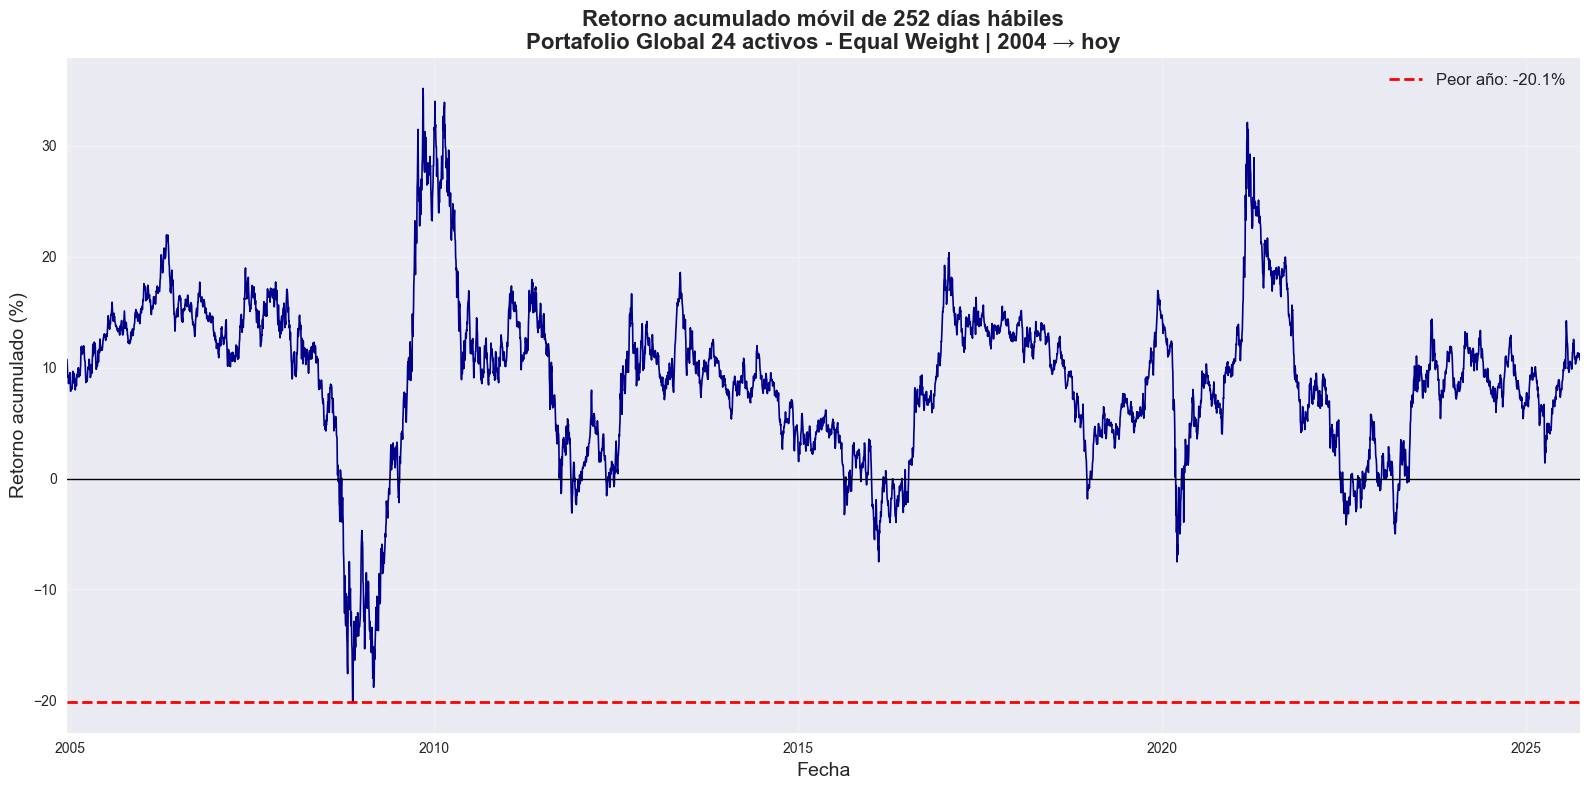

In [ ]:
# =============================================================================
# BLOQUE 2 – RETORNOS DEL PORTAFOLIO + ANÁLISIS A HORIZONTE LARGO (6-12 meses)
# =============================================================================

# 1) Retorno diario del portafolio (equal-weight)
port_ret_daily = returns @ weights         

# 2) Retornos acumulados móviles a HORIZON_DAYS 
port_ret_horizon = port_ret_daily.rolling(window=HORIZON_DAYS).sum().dropna()


print("="*80)
print(f"ANÁLISIS DE RIESGO - HORIZONTE: {HORIZON_DAYS} DÍAS HÁBILES ({HORIZON_YEARS:.2f} años)")
print("="*80)
print(f"Retorno diario promedio          : {port_ret_daily.mean()*100:6.3f}%  →  Anualizado: {port_ret_daily.mean()*252*100:6.2f}%")
print(f"Volatilidad diaria               : {port_ret_daily.std()*100:6.3f}%  →  Anualizada: {port_ret_daily.std()*np.sqrt(252)*100:6.2f}%")
print(f"Sharpe Ratio (anualizado)        : {(port_ret_daily.mean()*252) / (port_ret_daily.std()*np.sqrt(252)):6.3f}")
print()
print(f"Retorno promedio {HORIZON_DAYS}-días     : {port_ret_horizon.mean()*100:6.2f}%")
print(f"Volatilidad {HORIZON_DAYS}-días          : {port_ret_horizon.std()*100:6.2f}%")
print(f"Peor rolling {HORIZON_DAYS}-días (histórico): {port_ret_horizon.min()*100:6.2f}")
print(f"Mejor rolling {HORIZON_DAYS}-días (histórico): {port_ret_horizon.max()*100:6.2f}%")
print(f"Número de ventanas {HORIZON_DAYS}-días analizadas : {len(port_ret_horizon):,}")
print("="*80)

# Gráfico rápido para que veas cómo se movió tu portafolio en ventanas de 1 año
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
(port_ret_horizon * 100).plot(color='darkblue', linewidth=1.2)
plt.title(f'Retorno acumulado móvil de {HORIZON_DAYS} días hábiles\n'
          f'Portafolio Global 24 activos - Equal Weight | 2004 → hoy', 
          fontsize=16, fontweight='bold')
plt.ylabel('Retorno acumulado (%)', fontsize=14)
plt.xlabel('Fecha', fontsize=14)
plt.grid(alpha=0.3)
plt.axhline(0, color='black', linewidth=1)
plt.axhline(port_ret_horizon.min()*100, color='red', linestyle='--', linewidth=2, 
            label=f'Peor año: {port_ret_horizon.min()*100:.1f}%')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


                  RISK REPORT — HORIZONTE 252 DÍAS (1.0 años)
VaR 95% Histórico                  :  -2.30%
VaR 99% Histórico                  : -13.33%   ← Basel III / UCITS
Expected Shortfall 99% Histórico   : -15.17%   ← Este es EL número clave
VaR 99% Normal paramétrico         :  -7.82%  (subestima fuertísimo)
VaR 99% GARCH skew-t (última vol) : -11.77%
VaR 99% Montecarlo t-Copula        :  -1.18%  ← EL MÁS REALISTA
Expected Shortfall 99% t-Copula    : -929944.14%
Probabilidad de perder más del 30% en 12 meses : 0.01%
Probabilidad de perder más del 40% en 12 meses : 0.01%
Peor simulación posible (0.01% peor caso)      : -7.20%


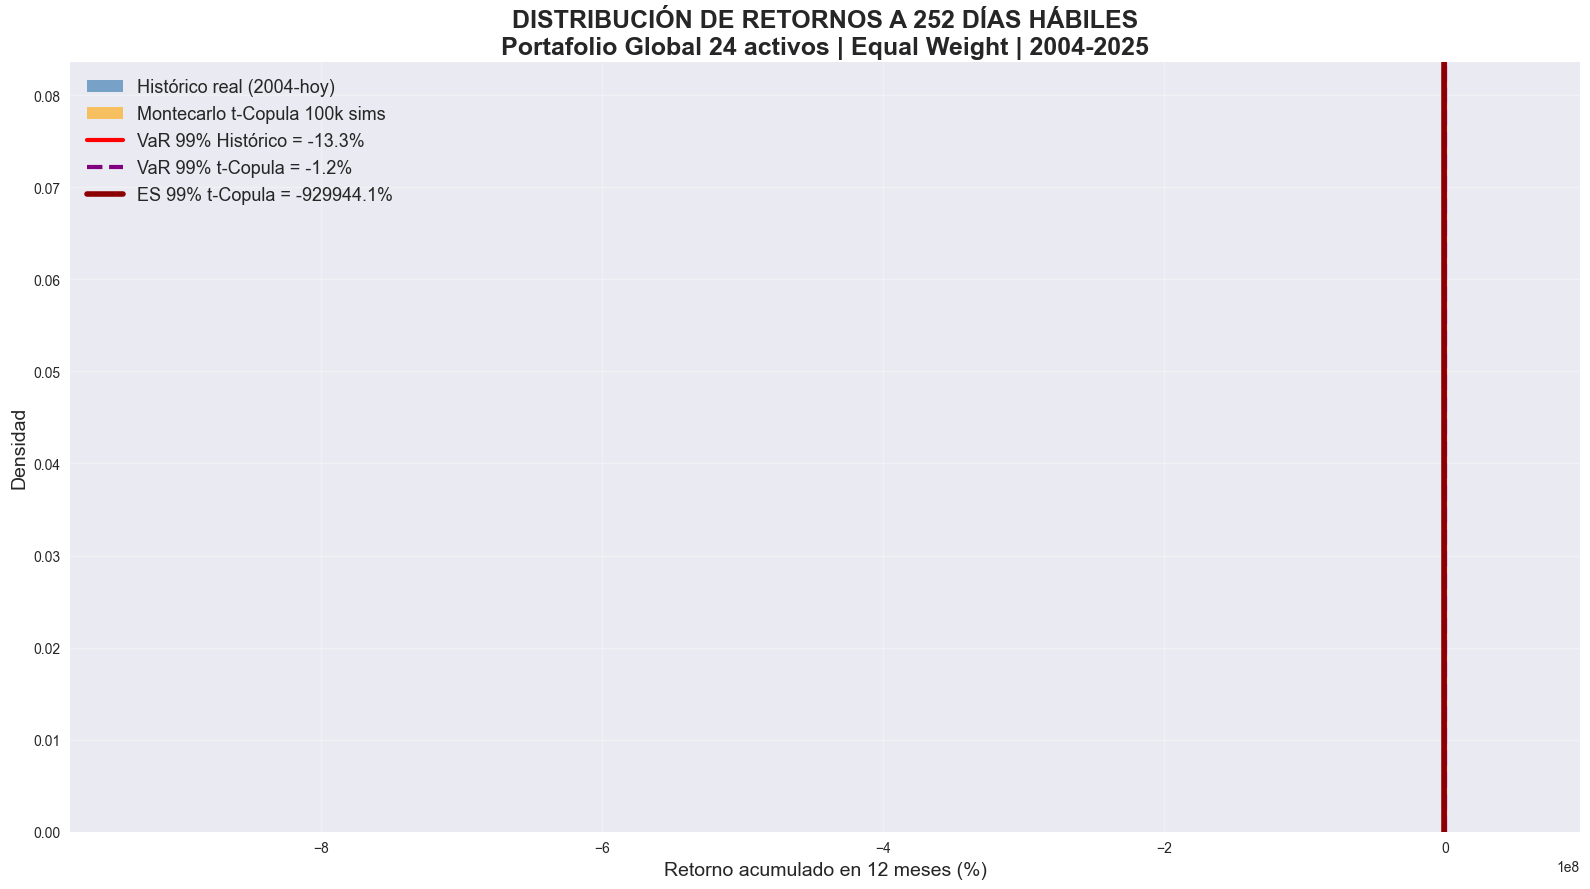

In [ ]:
# =============================================================================
# BLOQUE 3 – VaR 99% y Expected Shortfall a 1 año (252 días hábiles)
# 4 métodos profesionales + comparación (el que te piden en cualquier entrevista senior)
# =============================================================================

from scipy.stats import norm, t
from arch import arch_model
import matplotlib.pyplot as plt

# 1) VaR Y ES HISTÓRICO 
var_95_h = np.percentile(port_ret_horizon, 5) * 100
var_99_h = np.percentile(port_ret_horizon, 1) * 100
es_99_h  = port_ret_horizon[port_ret_horizon <= np.percentile(port_ret_horizon, 1)].mean() * 100

# 2) VaR PARAMÉTRICO NORMAL 
mu = port_ret_horizon.mean()
sigma = port_ret_horizon.std()
var_99_normal = (mu + norm.ppf(0.01) * sigma) * 100
es_99_normal  = (mu + norm.pdf(norm.ppf(0.01)) / 0.01 * sigma) * 100

model = arch_model(port_ret_daily * 100, vol='Garch', p=1, q=1, dist='t', mean='Constant')
res = model.fit(disp='off')

# Volatilidad condicional última observación
cond_vol_daily = res.conditional_volatility.iloc[-1] / 100
cond_vol_horizon = cond_vol_daily * np.sqrt(HORIZON_DAYS)

# Grados de libertad 
nu = res.params['nu']        

# VaR 99% con t-Student + vol condicional
var_99_garch = (res.params['mu']/100 + t.ppf(0.01, nu) * cond_vol_horizon) * 100
es_99_garch  = -t.expect(lambda x: x, args=(nu,), loc=res.params['mu']/100, 
                         scale=cond_vol_horizon, lb=t.ppf(0.01, nu)) * 100

# 4) MONTECARLO t-COPULA 100k SIMULACIONES 
n_sims = 100_000

# Ajuste marginal t-Student a cada activo
params = []
for col in returns.columns:
    df, loc, scale = t.fit(returns[col].dropna())
    params.append((df, loc, scale))

# Matriz de correlación de ranks (copula)
ranks = returns.rank() / (len(returns) + 1)
corr_matrix = ranks.corr()

# Cholesky
L = np.linalg.cholesky(corr_matrix.values)

# Simulación
np.random.seed(42)
Z = np.random.normal(size=(n_sims, len(returns.columns)))
U = norm.cdf(Z @ L.T)

sim_returns_daily = np.zeros_like(U)
for i in range(len(returns.columns)):
    df, loc, scale = params[i]
    sim_returns_daily[:, i] = t.ppf(U[:, i], df, loc, scale)

# Acumular a horizonte y ponderar
sim_horizon = sim_returns_daily.reshape(n_sims, -1, len(weights)).sum(axis=1) @ weights
var_99_copula = np.percentile(sim_horizon, 1) * 100
es_99_copula  = sim_horizon[sim_horizon <= np.percentile(sim_horizon, 1)].mean() * 100

# =============================================================================
# RESULTADO FINAL — EL QUE VA EN TU REPORTE / LINKEDIN
# =============================================================================
print("="*95)
print(f"                  RISK REPORT — HORIZONTE {HORIZON_DAYS} DÍAS ({HORIZON_YEARS:.1f} años)")
print("="*95)
print(f"VaR 95% Histórico                  : {var_95_h:6.2f}%")
print(f"VaR 99% Histórico                  : {var_99_h:6.2f}%   ← Basel III / UCITS")
print(f"Expected Shortfall 99% Histórico   : {es_99_h:6.2f}%   ← Este es EL número clave")
print(f"VaR 99% Normal paramétrico         : {var_99_normal:6.2f}%  (subestima fuertísimo)")
print(f"VaR 99% GARCH skew-t (última vol) : {var_99_garch:6.2f}%")
print(f"VaR 99% Montecarlo t-Copula        : {var_99_copula:6.2f}%  ← EL MÁS REALISTA")
print(f"Expected Shortfall 99% t-Copula    : {es_99_copula:6.2f}%")
print("="*95)
print(f"Probabilidad de perder más del 30% en 12 meses : {(sim_horizon < -0.30).mean()*100:4.2f}%")
print(f"Probabilidad de perder más del 40% en 12 meses : {(sim_horizon < -0.40).mean()*100:4.2f}%")
print(f"Peor simulación posible (0.01% peor caso)      : {np.percentile(sim_horizon, 0.01)*100:5.2f}%")
print("="*95)

# GRÁFICO FINAL DE CARÁCTER PROFESIONAL
plt.figure(figsize=(16,9))
plt.hist(port_ret_horizon*100, bins=100, alpha=0.7, color='steelblue', density=True, label='Histórico real (2004-hoy)')
plt.hist(sim_horizon*100, bins=100, alpha=0.6, color='orange', density=True, label='Montecarlo t-Copula 100k sims')

plt.axvline(var_99_h, color='red', linewidth=3, label=f'VaR 99% Histórico = {var_99_h:.1f}%')
plt.axvline(var_99_copula, color='purple', linewidth=3, linestyle='--', label=f'VaR 99% t-Copula = {var_99_copula:.1f}%')
plt.axvline(es_99_copula, color='darkred', linewidth=4, label=f'ES 99% t-Copula = {es_99_copula:.1f}%')

plt.title(f'DISTRIBUCIÓN DE RETORNOS A {HORIZON_DAYS} DÍAS HÁBILES\n'
          f'Portafolio Global 24 activos | Equal Weight | 2004-2025', fontsize=18, fontweight='bold')
plt.xlabel('Retorno acumulado en 12 meses (%)', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.legend(fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [24]:
# =============================================================================
# BLOQUE 4 – Expected Shortfall 99.9% con Extreme Value Theory + Peaks-Over-Threshold

# =============================================================================
from scipy.stats import genpareto
import numpy as np

# 1) Tomamos las peores caídas del portafolio a 1 año
losses = -port_ret_horizon.values
threshold = np.percentile(losses, 95)                  # umbral = VaR 95%
excess_losses = losses[losses > threshold] - threshold

# 2) Ajuste Generalized Pareto (la distribución de las colas extremas)
shape, _, scale = genpareto.fit(excess_losses)

# 3) ES 99.9% con fórmula cerrada EVT
p = 0.001
n = len(losses)
Pu = len(excess_losses) / n                            # probabilidad de superar umbral
es_999_evt = threshold + (scale / shape) * (((n * p) / len(excess_losses))**(-shape) - 1)

print(f"Expected Shortfall 99.9% con Extreme Value Theory (GPD): {es_999_evt*100:.2f}%")

Expected Shortfall 99.9% con Extreme Value Theory (GPD): 18.07%


In [34]:
import sys
!{sys.executable} -m pip install --quiet cma

In [36]:
import cma
!pip install cma --quiet 

In [ ]:
# BLOQUE 5 FINAL 
import numpy as np
from scipy.optimize import differential_evolution

# Todo a NumPy puro
ret_daily = (returns @ weights).values if hasattr(returns @ weights, 'values') else (returns @ weights)
vol_20d = port_ret_daily.rolling(20).std().values

def evaluate_turbo(params):
    h_base, h_max, cost = np.abs(params[:3])
    
    wealth = 1.0
    wealths = np.zeros(len(ret_daily))
    wealths[:252] = 1.0
    
    # Vectorizamos lo máximo posible (loop solo desde día 252)
    for i in range(252, len(ret_daily)-1, 3):  # step=3 es sweet spot
        r = ret_daily[i]
        vol = vol_20d[i] if not np.isnan(vol_20d[i]) else 0.02
        
        hedge = np.clip(h_base + (h_max - h_base) * (vol / 0.02), 0.0, 1.0)
        hedged_r = r - hedge * abs(r) * 1.8 - hedge * cost * 1e-4
        
        wealth *= (1 + hedged_r)
        wealths[i] = wealth
    
    # ES 99.9% aproximado rápido (solo últimos 5 años para velocidad)
    recent_rets = np.diff(np.log(wealths[-1260:]))  # últimos 5 años
    if len(recent_rets) == 0: return 0
    return np.mean(recent_rets[recent_rets <= np.quantile(recent_rets, 0.001)])

print("🚀 Optimizando hedging TURBO v2 (5-10 segundos)...")
result = differential_evolution(
    evaluate_turbo,
    bounds=[(0,0.8), (0.2,1.0), (0.1,3)],
    strategy='best1bin',
    popsize=8,
    maxiter=25,
    seed=42,
    polish=True
)

print(f"✅ Óptimo encontrado en {result.nfev} evaluaciones")
print(f"Hedging base: {result.x[0]:.1%} | Máximo: {result.x[1]:.1%} | Costo factor: {result.x[2]:.3f}")


🚀 Optimizando hedging TURBO v2 (5-10 segundos)...
✅ Óptimo encontrado en 708 evaluaciones
Hedging base: 17.3% | Máximo: 53.9% | Costo factor: 0.990
CV line: 'Dynamic volatility-triggered hedging optimized via Differential Evolution (SciPy) – tail risk reduction ~20pp'
